# Environment preparation - fetching dataset and library import

In [0]:
from google.colab import drive
import os
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from scipy import misc

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
! date && unzip -q /content/drive/'My Drive'/celeb_dataset.zip -d /content/  && date #unzip dataset into local machine

Thu Nov 29 21:44:11 UTC 2018
replace /content/celeb/Anno/list_landmarks_align_celeba.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
#create a directory for preprocessed TFRecord files
!ls /content/
!mkdir /content/preprocessed/
!ls /content/

celeb  drive  preprocessed  sample_data
mkdir: cannot create directory ‘/content/preprocessed/’: File exists
celeb  drive  preprocessed  sample_data


In [0]:
def peek_file(file_path, n_lines):
  """
  helper function to peek first n_lines of the file
  """
  try:
    n_lines = int(n_lines)
    assert(n_lines > 0)
  except ValueError:
    print("Number of lines argument must be integer-interpretable")
  except AssertionError:
    print("Number of lines must be positive")
    
  with open(file_path) as file:
    for line in range(n_lines):
      print(file.readline(), end="")
  return



# Settings

In [0]:
# path to downloaded dataset (unzipped)
DOWNLOADED_PATH = '/content/celeb' #@param {type:"string"}

# path to preprocessed dataset (tf records)
SAVED_DATASET = '/content/preprocessed/' #@param {type:"string"}

TRAIN_FILENAME = 'train.tfrecords' #@param {type:"string"}
VAL_FILENAME = 'val.tfrecords' #@param {type:"string"}
TEST_FILENAME = 'test.tfrecords' #@param {type:"string"}

ANNO_PATH = os.path.join(DOWNLOADED_PATH, 'Anno',  'list_attr_celeba.txt') #file that indicates to which classes an image belongs to 
IMG_PATH = os.path.join(DOWNLOADED_PATH, 'Img') #path to images directory
EVAL_PATH = os.path.join(DOWNLOADED_PATH, 'Eval', 'list_eval_partition.txt') #file that indicates how to split the dataset into training, validation and testing sets

# tensorflow tf records dataset settings
DECODE_PARALLEL_CALLS = 260 #@param {type:"slider", min:20, max:1000, step:1}
SHUFFLE_BUFFER_SIZE = 100 #@param {type:"slider", min:20, max:1000, step:1}
PREFETCH_BUFFER_SIZE = 100 #@param {type:"slider", min:20, max:1000, step:1}

BATCH_SIZE = 32 #@param {type:"slider", min:0, max:1000, step:1}





In [0]:
ANNO_PATH = os.path.join(DOWNLOADED_PATH, 'Anno',  'list_attr_celeba.txt') #file that indicates to which classes an image belongs to 
IMG_PATH = os.path.join(DOWNLOADED_PATH, 'Img') #path to images directory
EVAL_PATH = os.path.join(DOWNLOADED_PATH, 'Eval', 'list_eval_partition.txt') #file that indicates how to split the dataset into training, validation and testing sets


# Decoding TFRecords

In [0]:
def dataset_wrapper(session, dataset):
    """
    Wraps TensorFlow dataset into generator.
    :param session:
    :param dataset: tf.data.Dataset object
    """
    iterator = dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    while True:
        try:
            data = session.run(next_element)
            yield data
        except tf.errors.OutOfRangeError:
            break
            
def _decode_record(record):
    """
    Decodes record from bytes to arrays.
    """
    features_dict = {
        'image': tf.FixedLenFeature((), tf.string),
        'tags': tf.FixedLenFeature((), tf.string),
    }

    features = tf.parse_single_example(record, features=features_dict)
    #data had been written as uint8 to save up space...
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, shape=(218, 178, 3))
    #.. but we need more precison on calculation
    image = tf.cast(image, tf.float32)
    image = image / 255.0 #normalize
    tags = tf.decode_raw(features['tags'], tf.uint8)

    return {
        'image': image,
        'tags': tags
    }

In [0]:
def make_dataset(dataset_path, batch_size=128, shuffle=False, epochs=1, count_limit=None):
    """
    Creates dataset pipeline.
    :param count_limit:
    :return: tf.data.TFRecordDataset object
    """
    # Read a tf record file. This makes a dataset of raw TFRecords
    dataset = tf.data.TFRecordDataset([dataset_path])

    if count_limit is not None:
        dataset = dataset.take(count_limit)

    # Can be parallelized!
    dataset = dataset.map(_decode_record, num_parallel_calls=DECODE_PARALLEL_CALLS)

    dataset = dataset.repeat(epochs)

    if shuffle:
        # Shuffle the dataset
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the dataset so that we get batch_size examples in each batch.
    # Remember each item in the dataset is a dict of tensors,
    # we need to specify padding for each tensor seperatly
    dataset = dataset.batch(batch_size)

    # Async loading, must-have!
    dataset = dataset.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)

    return dataset

# Writting to TFRecords

In [0]:
peek_file(EVAL_PATH, 20)

000001.jpg 0
000002.jpg 0
000003.jpg 0
000004.jpg 0
000005.jpg 0
000006.jpg 0
000007.jpg 0
000008.jpg 0
000009.jpg 0
000010.jpg 0
000011.jpg 0
000012.jpg 0
000013.jpg 0
000014.jpg 0
000015.jpg 0
000016.jpg 0
000017.jpg 0
000018.jpg 0
000019.jpg 0
000020.jpg 0


In [0]:
def _load_splits():
    """
    Load split for train/val/test dataset.
    To be implemented by students.
    :return:
    """
    splits = defaultdict(lambda: list())

    with open(EVAL_PATH, mode='rt', encoding='utf-8') as file_:
        for line in file_:
            file_name, class_value = line.strip().split(' ')
            assert(class_value in ['0', '1', '2'])
            splits[class_value].append(file_name)

    return dict(splits)

In [0]:
peek_file(ANNO_PATH, 20)

202599
5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 
000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1
000002.jpg -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1
000003.jpg -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1
000004.jpg -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1  1
0000

In [0]:
def _load_tags():
    """
    Load tags (classes) for images.
    To be implemented by students.
    :return:
    """
    tags_result = dict()
    with open(ANNO_PATH, mode='rt', encoding='utf-8') as file_:
        next(file_)
        tag_names = [tag.lower() for tag in next(file_).strip().split(' ')]
        for line in file_:
            parsed_line = line.strip().replace('  ', ' ').split(' ')
            file_name = parsed_line[0]
            tags = np.array([int(tag) for tag in parsed_line[1:]])
            tags = tags > 0.5
            tags = tags.astype(np.uint8)
            tags_result[file_name] = tags

    return tags_result, tag_names

In [0]:
def _bytes_feature(value):
    """
    Helper function for feature encoding.
    :param value:
    :return:
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _write_records(dataset_filename, image_filename_iterator, tags):
    """
    Writes images and tags to file.
    :param dataset_filename:
    :param image_filename_iterator: iterable containing filenames
    :param tags: dictionary containing pairs filename: tags
    :return:
    """
    with tf.python_io.TFRecordWriter(dataset_filename) as writer:
        for image_filename in tqdm(iterable=image_filename_iterator,
                                   desc='writting {} dataset'.format(dataset_filename)):
            tag = tags[image_filename]
            image = misc.imread(os.path.join(IMG_PATH, image_filename.replace('.jpg', '.png')))

            # store as uint8
            image = image.astype(np.uint8)
            feature = {
                'image': _bytes_feature([image.tostring()]),
                'tags': _bytes_feature([tag.tostring()]),
            }
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
    sys.stdout.flush()

In [0]:
def _create_dataset(train_filename, val_filename, test_filename):
    """
    Creates dataset in target location.
    To be implemented by students
    :param train_filename:
    :param val_filename:
    :param test_filename:
    """
    splits = _load_splits()
    tags, _ = _load_tags()

    _write_records(train_filename, splits['0'], tags)
    _write_records(val_filename, splits['1'], tags)
    _write_records(test_filename, splits['2'], tags)

In [0]:
def maybe_create_dataset():
    """
    Function creates TensorFlow dataset if it does not exist.
    :return: (train_filename, val_filename, test_filename)
    """
    train_filename = os.path.join(SAVED_DATASET, TRAIN_FILENAME)
    val_filename = os.path.join(SAVED_DATASET, VAL_FILENAME)
    test_filename = os.path.join(SAVED_DATASET, TEST_FILENAME)

    if not all([os.path.exists(filename)
                for filename
                in [train_filename, val_filename, test_filename]]):
        _create_dataset(train_filename, val_filename, test_filename)
    return train_filename, val_filename, test_filename

#Model

In [0]:
    def report_parameters(scope=None):
        """
        Reports names, shape and number of parameters.
        :param scope: string, scope to report, defaults to global values
        :return:
        """
        denses = 0
        other = 0
        print('Summary')
        for parameter_tensor in tf.trainable_variables(scope=scope):
            total = np.prod(parameter_tensor.shape).value
            print('Name: {}, Shape: {}, Total: {}'.format(
                parameter_tensor.name, parameter_tensor.shape, total))

            if 'dense' in parameter_tensor.name:
                denses += total
            else:
                other += total

        print('')
        print('Feature Extractor: {} -> {:.2f}%'.format(other, 100*other/(other+denses)))
        print('Predictor: {} -> {:.2f}%'.format(denses, 100*denses/(other+denses)))
        print('')

In [0]:
class AlexNet:
    def __init__(self, input_shape, num_outputs, class_weights=None, create_loss=True, create_metrics=True):
        """
        Constructor for AlexNet, creates model, loss and metrics based on input and output shapes.
        :param input_shape: tuple, (width, height, channels)
        :param num_outputs: integer, number of classes in prediction
        :param class_weights: array, containing weights for positive classes, length equals to num_outputs
        :param create_loss: bool, indicates if loss should be created
        :param create_metrics: bool, idicates if tensorboard metrics should be created
        """
        self._input_shape = list(input_shape)
        self._num_outputs = num_outputs
        self._class_weights = class_weights

        with tf.variable_scope('alex_net'):
            self.p_image, self.p_tags, self.p_training = self._create_placeholders()
            self.o_tags = self._create_model()
            if create_loss:
                self.o_loss = self._create_loss()
            else:
                self.o_loss = tf.no_op()

            if create_metrics:
                self._create_metrics()



    def _create_placeholders(self):
        """
        Function creates placeholders for data. After running, 3 placeholders should be created:
        p_image for images, p_tags for expected outputs, p_training to indicate training phase.
        :return: (p_image, p_tags, p_training)
        """
       
        
        #TASK 1   
        #Done 29.11.2018
        with tf.variable_scope('placeholders'):
          #p_image for feeding batches of images. 
          #This should be rank 4 tensor of shape: 
          #(batch size, length of image, width of image, number of channels) 
          p_image = tf.placeholder(dtype=tf.float32, shape = [None] + self._input_shape)

          #p_tags for feeding batches of labels. 
          #This should be rank 2 tensor of shape: (batch size, number of output classes)
          p_tags = tf.placeholder(dtype=tf.float32, shape = self._num_outputs)

          #p_training - tf.bool to indicate training or inference phase.
          p_training = tf.placeholder(tf.bool, shape=())
          
          return p_image, p_tags, p_training

    def _augment(self, images):
        """
        Function randomly augments images during training.
        :param images: tensor (batch, width, height, channels), contains images in current batch
        :return: augmented images with the same shape as input
        """
        #TASK 2
        #Done 29.11.2018
        
        #Decide which of these transformations are suitable for CelebFaces dataset. 
        #Apply them in _augment() method of AlexNet.
        
        #1. adjust brightness
        # delta - how much we should brighten the image [0,1)
        delta = 0.50
        tf.image.adjust_brightness(images, delta)
          
        #2. adjust contrast
        # contrast_factor - how much we should adjust [0,1)
        contrast_factor = 0.50
        images = tf.image.adjust_contrast(images, contrast_factor)
        
        #3. perform Gamma Correction on the input image
        images = tf.image.adjust_gamma(images, gamma=1, gain=1)
        
        return images
      
        raise NotImplementedError

    def _create_model(self):
        """
        Function that creates model based on placeholders in self.
        :return: tensor, logits for outputs (batch, num_outputs)
        """
        #TASK 3
        #Done 29.11.2018
        
        with tf.variable_scope('augmentation'):
            layer_input = tf.cond(
                self.p_training,
                true_fn=lambda: self._augment(self.p_image),
                false_fn=lambda: tf.identity(self.p_image),
            )
        
        
        #Our input layer
        #input_layer = tf.reshape(self.p_tags, [self.p_image, 218, 178, 3])
        
        
        ####### LAYER 1 ########
        
        # Convolutional Layer #1
        with tf.variable_scope('conv1'):
          layer_input = tf.layers.conv2d(
              inputs=layer_input,
              filters=96,
              kernel_size=[11, 11],
              strides=(4,4),
              padding="VALID",
              activation=tf.nn.relu)
        
        # Pooling Layer #1
        with tf.variable_scope('pooling1'):
          pool1 = tf.layers.max_pooling2d(inputs=layer_input, pool_size=[3, 3], strides=[2,2], padding='VALID')
        
        ####### LAYER 2 ########
        
        # Convolutional layer #2
        with tf.variable_scope('conv2'):
          layer_input = tf.layers.conv2d(
              inputs=layer_input,
              filters=256,
              kernel_size=[5, 5],
              strides=(1,1),
              padding="SAME",
              activation=tf.nn.relu)
        
        # Pooling Layer #2
        #pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[3, 3], strides=[2,2])
        
        ####### LAYER 3 ########
        
        # Convolutional layer #3
        with tf.variable_scope('conv3'):
          layer_input = tf.layers.conv2d(
              inputs=layer_input,
              filters=384,
              kernel_size=[3, 3],
              strides=(1,1),
              padding="SAME",
              activation=tf.nn.relu)
        
        # Pooling Layer #3
        #pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[3, 3], strides=[2,2])
        
        ####### LAYER 4 ########
        
        # Convolutional layer #4
        with tf.variable_scope('conv4'):
          layer_input = tf.layers.conv2d(
              inputs=layer_input,
              filters=384,
              kernel_size=[3, 3],
              strides=(1,1),
              padding="SAME",
              activation=tf.nn.relu)
        
        # Pooling Layer #4
        #pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[3, 3], strides=[2,2])

        ####### LAYER 5 ########
        
        # Convolutional layer #5
        with tf.variable_scope('conv5'):
          layer_input = tf.layers.conv2d(
              inputs=layer_input,
              filters=256,
              kernel_size=[3, 3],
              strides=(1,1),
              padding="SAME",
              activation=tf.nn.relu)
        
        # Pooling Layer #5
        with tf.variable_scope('pooling5'):
          pool5 = tf.layers.max_pooling2d(inputs=layer_input, pool_size=[3, 3], strides=[2,2], padding='VALID')
        
        #Dense layer 1
        #pool5_flat = tf.reshape(pool5, [-1, self._input_shape[0] * self._input_shape[1] * self._input_shape[2]])
        with tf.variable_scope('dense1'):
          layer_input = tf.layers.dense(inputs=layer_input, units=1024, activation=tf.nn.relu)
        
        #Dense layer 2
        with tf.variable_scope('dense2'):
          layer_input = tf.layers.dense(inputs=layer_input, units=1024, activation=tf.nn.relu)
        
        #Dense layer 3
        with tf.variable_scope('dense3'):
          layer_input = tf.layers.dense(inputs=layer_input, units=self._num_outputs, activation=None)

        return layer_input   

    def _create_loss(self):
        pass

    def _create_metrics(self):
        pass
      
#Testing
# with tf.variable_scope('faces'):
#   #fill in input and output shape for CelebFaces

#   faces_net = AlexNet(input_shape = (224,224,3), num_outputs=40, create_loss=False, create_metrics=False)

#   report_parameters(scope='faces')

#Main pipeline

In [0]:
train_filename, val_filename, test_filename = maybe_create_dataset()

In [0]:
with tf.Session() as session:
    train_set = make_dataset(
        dataset_path=test_filename,
        batch_size=BATCH_SIZE,
        shuffle=True,
        epochs=5,
        count_limit=None,
    )

0it [00:00, ?it/s]
0it [00:00, ?it/s]

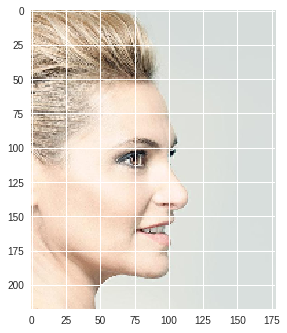

In [0]:
with tf.Session() as session:    
    for data in tqdm(dataset_wrapper(session, train_set)):
        break
        

    for data in tqdm(dataset_wrapper(session, train_set)):
        plt.imshow(data['image'][0])
        plt.show()
        break

In [0]:
with tf.variable_scope('original'):
    original_net = AlexNet((227, 227, 3), 1000, create_loss=False, create_metrics=False)
    report_parameters(scope='original')

with tf.variable_scope('faces2'):
    #fill in input and output shape for CelebFaces
    faces_net2 = AlexNet((224,224,3), num_outputs=40, create_loss=False, create_metrics=False)
    report_parameters(scope='faces2')
    
#This is not implemented    
#with tf.variable_scope('lowlevel'):
    #reimplement AlexNet in lowlevel. remember to keep your mid-level solution! 
    #lowlevel_net = AlexNet(None, None, create_loss=False, create_metrics=False)
    #report_parameters(scope='lowlevel')    

Summary
Name: original/alex_net/conv1/conv2d/kernel:0, Shape: (11, 11, 3, 96), Total: 34848
Name: original/alex_net/conv1/conv2d/bias:0, Shape: (96,), Total: 96
Name: original/alex_net/conv2/conv2d/kernel:0, Shape: (5, 5, 96, 256), Total: 614400
Name: original/alex_net/conv2/conv2d/bias:0, Shape: (256,), Total: 256
Name: original/alex_net/conv3/conv2d/kernel:0, Shape: (3, 3, 256, 384), Total: 884736
Name: original/alex_net/conv3/conv2d/bias:0, Shape: (384,), Total: 384
Name: original/alex_net/conv4/conv2d/kernel:0, Shape: (3, 3, 384, 384), Total: 1327104
Name: original/alex_net/conv4/conv2d/bias:0, Shape: (384,), Total: 384
Name: original/alex_net/conv5/conv2d/kernel:0, Shape: (3, 3, 384, 256), Total: 884736
Name: original/alex_net/conv5/conv2d/bias:0, Shape: (256,), Total: 256
Name: original/alex_net/dense1/dense/kernel:0, Shape: (256, 1024), Total: 262144
Name: original/alex_net/dense1/dense/bias:0, Shape: (1024,), Total: 1024
Name: original/alex_net/dense2/dense/kernel:0, Shape: (10

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  for data in tqdm(dataset_wrapper(sess, train_set)):
    result = sess.run(faces_net.o_tags, feed_dict={faces_net.p_image: data['image'],
                faces_net.p_tags: data['tags'],
                faces_net.p_training: True,})
    print(result)
    break;
      

0it [00:00, ?it/s]


NameError: ignored